In [2]:
import optuna
import numpy as np
import pandas as pd
from time import time

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

path_full = #Path here

columns = ['T_e','T_bb','tau_T','E','Mu','I','U']

DF_full = pd.read_csv(path_full,names=columns)

In [20]:
def get_folds(DF,n_fold=2):
    """
    This function splits dataset into train, test and validation AND makes different folds.
    Parameters:
      DF - dataframe which should be splitted.
      n_folds - number of folds (default = 2), intiger.
    Return:
      Train_x, Test_x, Val_x - list of folds for features in training/test/validation sets
      Train_y, Test_y, Val_y - list of folds for labels in training/test/validation sets
    """

    # Number of folds. Means that the whole dataset is divided into n_fold parts of equal sizes.
    DF.reset_index(drop=True,inplace=True)
    X = DF.drop(['I','U'],axis=1)
    Y = np.log(DF['I'])

    # Create the KFold object.
    k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=0)

    # Train and test indices for each fold:
    train_test_idx_in_folds = {k: (train, test) for k, (train, test) in enumerate(k_fold.split(DF))}

    # Choose indices of train and test sets from fold 0:
    fold = 0

    Train_x,Train_y =[],[]
    Test_x,Test_y = [],[]
    Val_x,Val_y = [],[]

    for i in range(n_fold):
        train_idx = train_test_idx_in_folds[i][0]
        test_idx = train_test_idx_in_folds[i][1]

        # I would like to have validation set. In this approach I'll naively split test set in two.
        # We could implement different way to split but I don't think that this is needed at this point.
        L = len(test_idx)//2

        # Pick input data for train and test sets (i.e., cleaned XRD intensities):
        Train_x.append(X.loc[train_idx])
        Test_x.append(X.loc[test_idx[:L]])
        Val_x.append(X.loc[test_idx[L:]])

        # Pick output data for train and test sets (i.e., sample dimensionalities):
        Train_y.append(Y.loc[train_idx])
        Test_y.append(Y.loc[test_idx[:L]])
        Val_y.append(Y.loc[test_idx[L:]])

    return(Train_x,Test_x,Val_x,Train_y,Test_y,Val_y)


def PredPlot_folds(model,Tr_x,Tr_y,Te_x,Te_y):
    """
    With this function I can iterate through the folds and execute fitting on each.
    Parameters:
      model - XGBRegression model
      Tr_x,Tr_Y,Te_x,Te_y - training and test data
      Validate - boolean value. If true model will be validated.
      Validation_set - data for validation (tuple of data)
      Verbose - set True to print out additional information
    """
    L = len(Tr_x)
    Y_pred = []
    for i in range(L):
        
        model.fit(Tr_x[i],Tr_y[i])
        pred = model.predict(Te_x[i])
        print('Fold',i,'MAE:',mean_absolute_error(Te_y[i],pred))
        Y_pred.append(pred)


    Scores_all = []
    f, ax = plt.subplots(1,L,figsize=[20,5])
    for i in range(L):
        ax[i].scatter(Te_y[i],Y_pred[i],s=5,c='k')
        minmin = int(min(min(Te_y[i]),min(Y_pred[i])))
        maxmax = int(max(max(Te_y[i]),max(Y_pred[i])))
        R2 = round(r2_score(Te_y[i],Y_pred[i]),4)
        MAE = round(mean_absolute_error(Te_y[i],Y_pred[i]),4)
        ax[i].plot([i for i in range(minmin,maxmax)],[i for i in range(minmin,maxmax)],c='r')
        ax[i].text(minmin,maxmax,'R2:'+str(R2))
        ax[i].text(minmin,maxmax*0.8,'MAE:'+str(MAE))
        ax[i].set_xlabel('True values')
        ax[i].set_ylabel('Predicted values')
        ax[i].set_title('Fold '+str(i+1))
        Scores_all.append([R2,MAE])
    Scores_all = np.array(Scores_all)

    print('Mean R2:',np.mean(Scores_all[:,0]))
    print('Mean MAE:',np.mean(Scores_all[:,1]))

    return(Y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)



def Plot_Pred(Y_test,pred):
    
    MAE = mean_absolute_error(Y_test,pred)
    R2 = r2_score(Y_test,pred)
    
    f, ax = plt.subplots(figsize=[10,6])
    ax.scatter(Y_test,pred,s=3,c='k')
    
    maxmax = int(max([max(Y_test),max(pred)]))
    minmin = int(min([min(Y_test),min(pred)]))
    
    ax.plot([i for i in range(minmin,maxmax)],[i for i in range(minmin,maxmax)],color='r')
    
    ax.set_ylabel('Predicted I')
    ax.set_xlabel('True I')
    
    _ = ax.text(minmin,maxmax,'MAE: '+str(MAE))
    _ = ax.text(minmin,maxmax*0.8,'R2: '+str(R2))

Here I define hyperparameter optimization for optuna

In [4]:
def objective(trial):
    param = {
        'alpha': trial.suggest_float('alpha', 10**-6, 10,log=True),
        'gamma': trial.suggest_float('gamma',10**-6,10,log=True),
        'kernel': trial.suggest_categorical('kernel',['rbf','laplacian','sigmoid','cosine','chi2','additive_chi2'])
        }
    model = KernelRidge(**param)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(Y_test, y_pred)

I will try to use kernel ridge regression to predict I value. I'll do this for increasing dataset size.

In [76]:
def objective_CV(trial):
    
    # In this version of objective I'm checking all folds and use mean MAE as scoring
    
    param = {
        'alpha': trial.suggest_float('alpha', 10**-6, 10,log=True),
        'gamma': trial.suggest_float('gamma',10**-6,10,log=True),
        'kernel': trial.suggest_categorical('kernel',['rbf','laplacian','sigmoid','cosine','chi2','additive_chi2'])
        }
    
    MAES = []
    model = KernelRidge(**param)
    L = len(Tr_x)
    
    for i in range(L):
        X_train, X_test = Tr_x[i], Te_x[i]
        Y_train, Y_test = Tr_y[i], Te_y[i]
        
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        MAES.append(mean_absolute_error(Y_test,y_pred))
    
    
    return(np.mean(MAES))

In [5]:
# This variable will store the best hyperparameters for each dataset size
# This will enable me to enqueue trials with already known good parameters.
# It will also be used for data analysis at the end of this study.
TRIALS = []
# these my previous best results I'm putting them here just for safety
#TRIALS.append({'alpha': 1.1604365320235597e-06, 'gamma': 0.12692843989068256, 'kernel': 'chi2'})
#TRIALS.append({'alpha': 1.5595332644826417e-06, 'gamma': 0.24488952136988373, 'kernel': 'chi2'})
#TRIALS.append({'alpha': 1.003933272031719e-06, 'gamma': 0.22320911359899115, 'kernel': 'chi2'})

# 5K set Optuna

In [6]:
DF_5k = DF_full.sample(5000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5k,n_fold=3)

In [ ]:
#We need to be really careful when calling optuna parameter range.

DF_5k = DF_full.sample(5000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5k,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')
param = study.optimize(objective, n_trials=50)
params = study.best_params
val = study.best_value
TRIALS.append(params)

In [8]:
print('Best value:',val)
print('Best parameters:\n',params)

Best value: 0.07697005927905562
Best parameters:
 {'alpha': 1.7988665591295244e-06, 'gamma': 0.16807204198046669, 'kernel': 'chi2'}


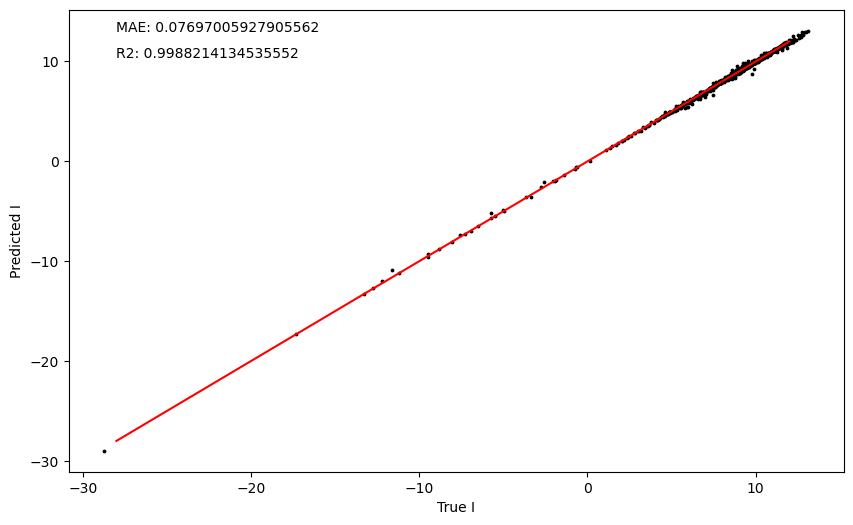

In [9]:
KRR = KernelRidge(**params)
KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

Fold 0 MAE: 0.07197950556099941
Fold 1 MAE: 0.06832430611465072
Fold 2 MAE: 0.06945396408403663
Mean R2: 0.9990333333333333
Mean MAE: 0.06993333333333333


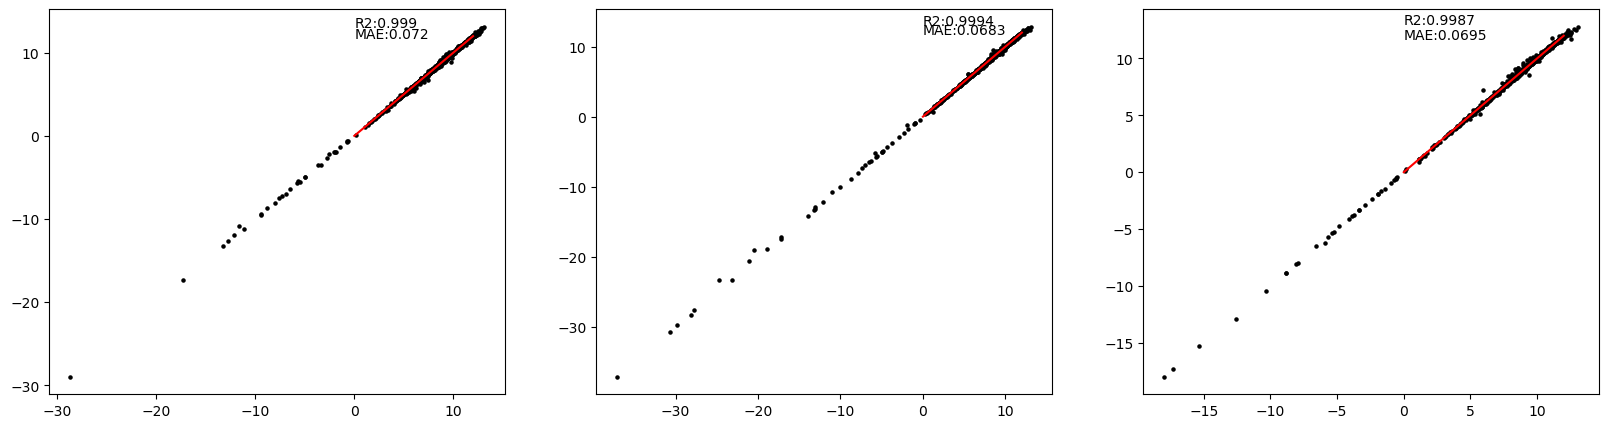

In [80]:
KRR = KernelRidge(**params)
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

### Cross validated objective

In [ ]:
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')
param = study.optimize(objective_corss_validated, n_trials=50)
params = study.best_params
val = study.best_value

In [10]:
print('Best value:',val)
print('Best parameters:\n',params)

Best value: 0.08045545895011927
Best parameters:
 {'alpha': 2.077867276606827e-06, 'gamma': 0.1318875624991601, 'kernel': 'chi2'}


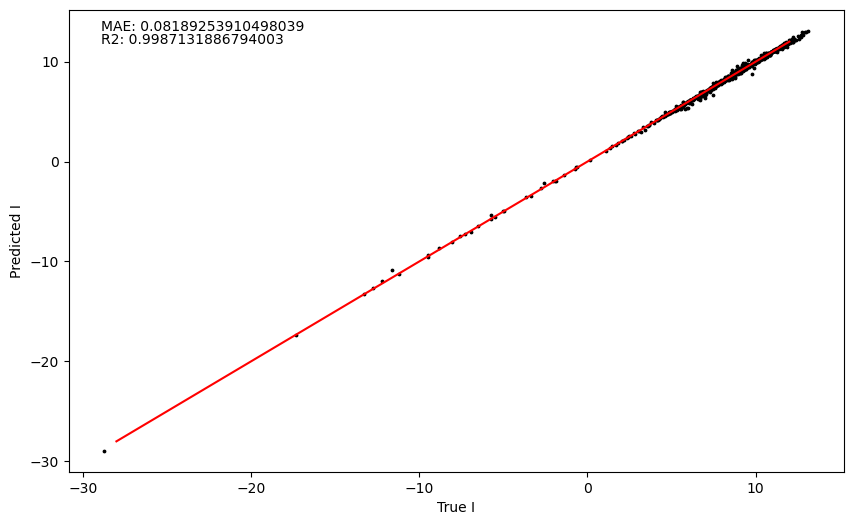

In [82]:
KRR = KernelRidge(**params)

KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

Fold 0 MAE: 0.08189253910498039
Fold 1 MAE: 0.07913268932437979
Fold 2 MAE: 0.08034114842099763
Mean R2: 0.9987666666666666
Mean MAE: 0.08043333333333334


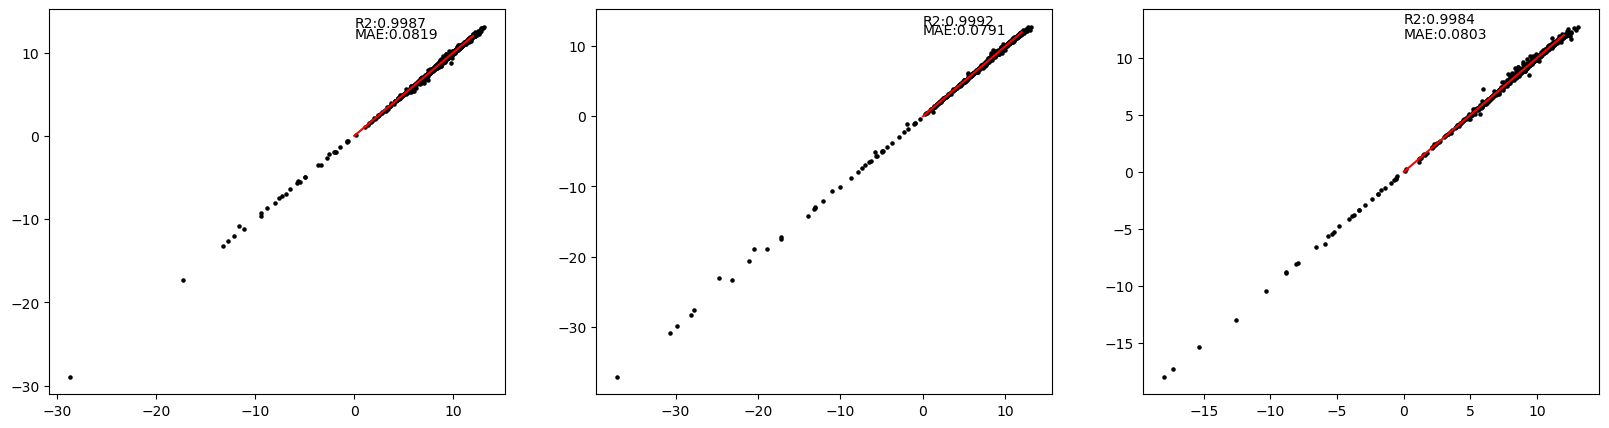

In [83]:
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

It seems that cross validated objective didn't made such difference for 5K set. I'll repeat with larger datasets. This might work much better if I increase number of optimizations to eg 100.

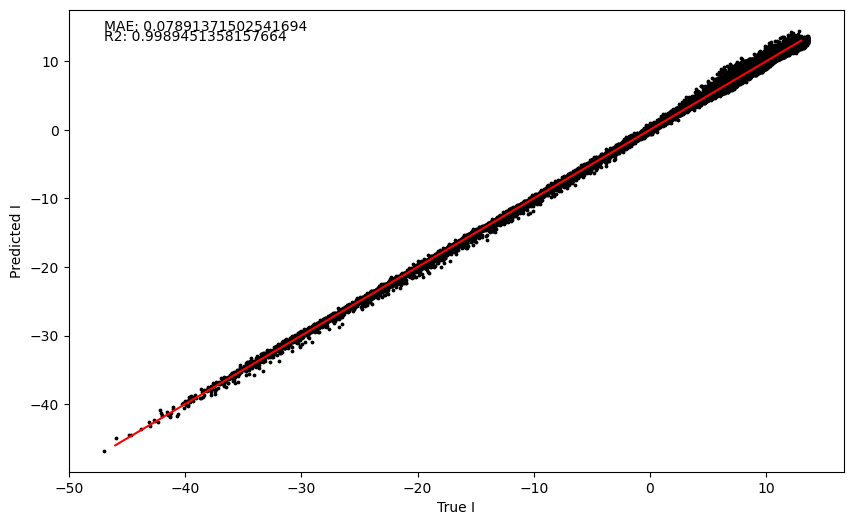

In [89]:
# Can't run on full dataset which is 18M due to memory issues (would need 75GB) but I can do this for 1M dataset. 

DF_1M = DF_full.sample(1000000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_1M,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
#KRR = KernelRidge(**params)

#KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

# 10K set

In [ ]:
from time import time
start = time()
# Using above results I will repeat the search with limited parameters
DF_10k = DF_full.sample(10000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_10k,n_fold=3)

X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')
param = study.optimize(objective, n_trials=100)
params = study.best_params
val = study.best_value
TRIALS.append(params)
stop = time()

In [11]:
print('Best value:',val)
print('Best parameters:\n',params)
print('Execution time in seconds:',stop-start,'In minutes:',(stop-start)//60)

Best value: 0.04382734602807617
Best parameters:
 {'alpha': 1.5595332644826417e-06, 'gamma': 0.24488952136988373, 'kernel': 'chi2'}
Execution time in seconds: 1149.2952337265015 In minutes: 19.0


Fold 0 MAE: 0.04382734602807617
Fold 1 MAE: 0.04471633018451509
Fold 2 MAE: 0.04662643081973477
Mean R2: 0.9996333333333333
Mean MAE: 0.045033333333333335


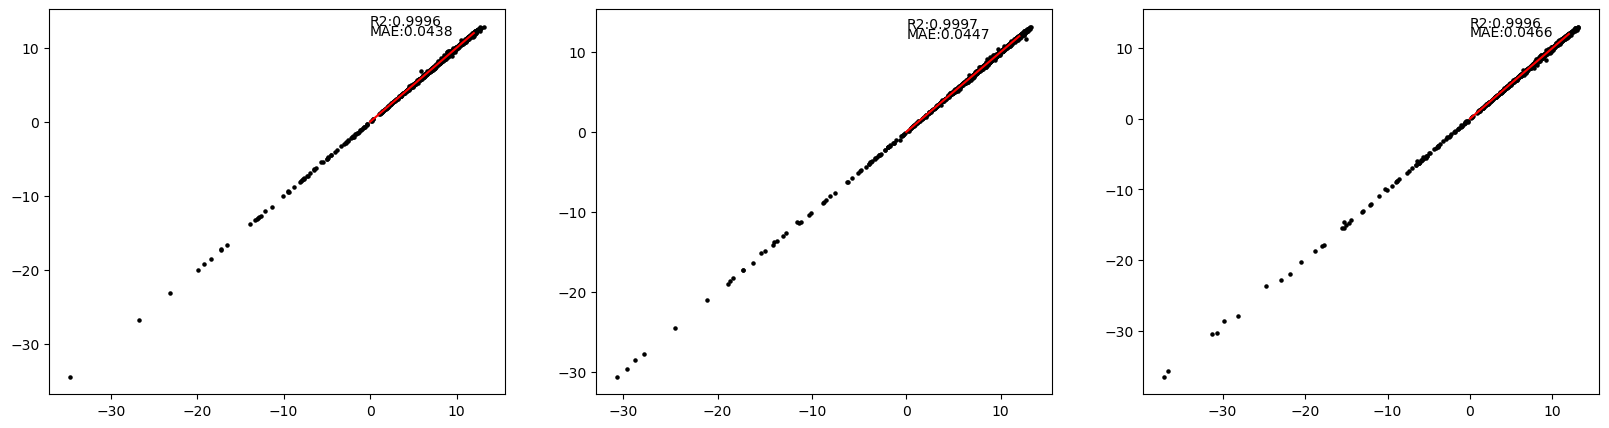

In [91]:
KRR = KernelRidge(**params)
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

Best parameters:
 {'alpha': 1.5595332644826417e-06, 'gamma': 0.24488952136988373, 'kernel': 'chi2'}
Execution time in seconds: 1149.2952337265015 In minutes: 19.0

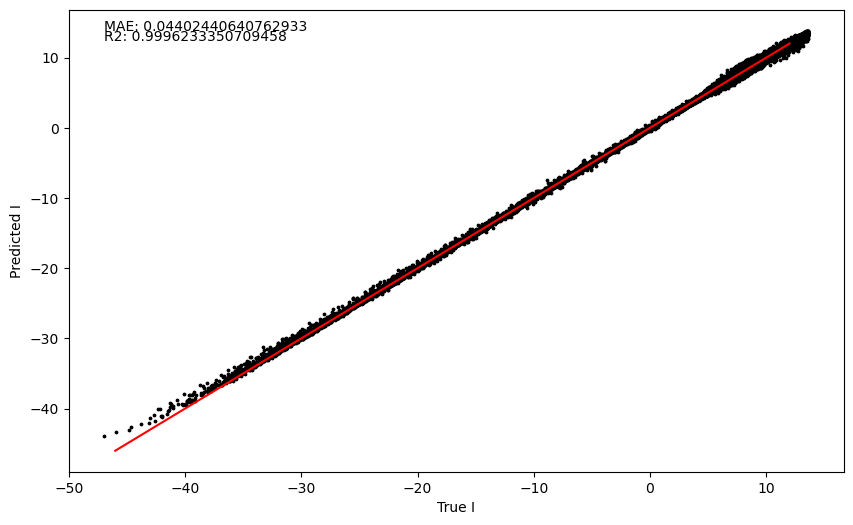

In [92]:
# Can't run on full dataset which is 18M due to memory issues (would need 75GB) but I can do this for 1M dataset. 

DF_1M = DF_full.sample(1000000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_1M,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
#KRR = KernelRidge(**params)

#KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

# 15K set

In [59]:
DF_15k = DF_full.sample(15000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_15k,n_fold=3)

In [ ]:
start = time()
# Using above results I will repeat the search with limited parameters

X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')

#This function will use previous best parameters as starting point
for T in TRIALS:
    study.enqueue_trial(T)
    
param = study.optimize(objective, n_trials=100)
params = study.best_params
val = study.best_value
TRIALS.append(params)
stop = time()

In [12]:
print('Best value:',val)
print('Best parameters:\n',params)
print('Execution time in seconds:',stop-start,'In minutes:',(stop-start)//60)

Best value: 0.040821734643656196
Best parameters:
 {'alpha': 1.003933272031719e-06, 'gamma': 0.22320911359899115, 'kernel': 'chi2'}
Execution time in seconds: 1077.2979834079742 In minutes: 17.0


Fold 0 MAE: 0.040821734643656196
Fold 1 MAE: 0.041439818722117314
Fold 2 MAE: 0.04378562633655819
Mean R2: 0.9997000000000001
Mean MAE: 0.042


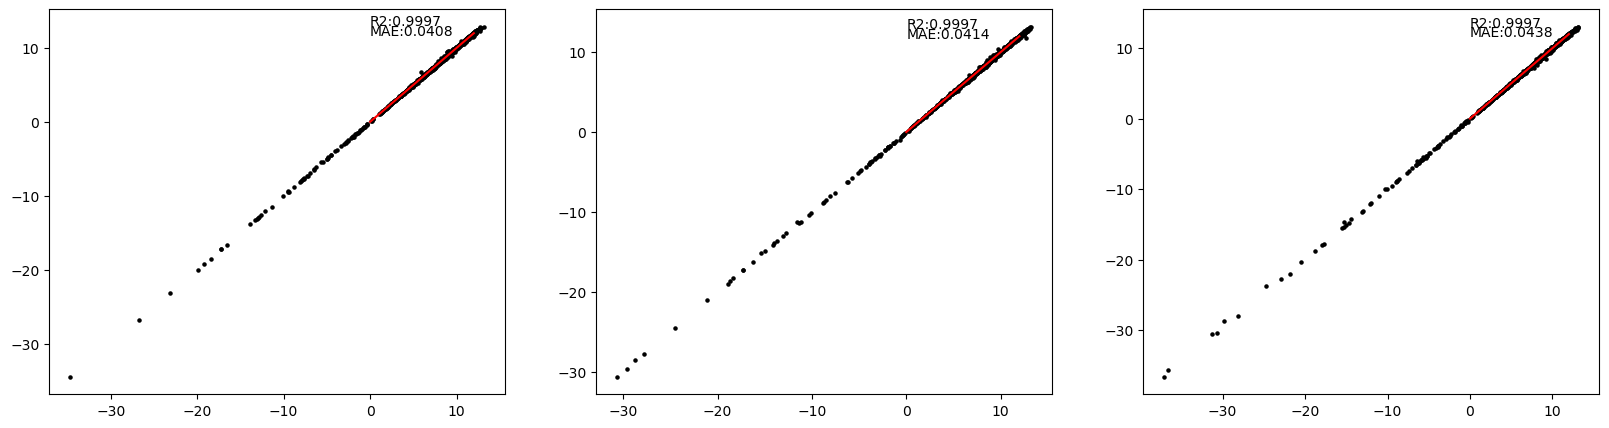

In [98]:
KRR = KernelRidge(**params)
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

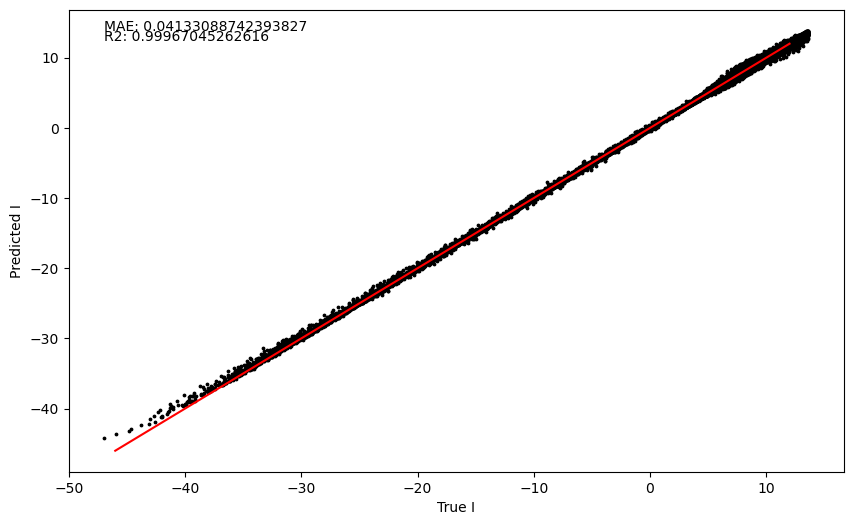

In [99]:
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_1M,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
#KRR = KernelRidge(**params)

#KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

# 30K set

In [ ]:
from time import time
start = time()
# Using above results I will repeat the search with limited parameters
DF_30k = DF_full.sample(30000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_30k,n_fold=3)

X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')

#This function will use previous best parameters as starting point
for T in TRIALS:
    study.enqueue_trial(T)
    
param = study.optimize(objective, n_trials=50,gc_after_trial=True)
params = study.best_params
val = study.best_value
TRIALS.append(params)
stop = time()

In [16]:
print('Best value:',val)
print('Best parameters:\n',params)
print('Execution time in seconds:',stop-start,'In minutes:',(stop-start)//60)

Best value: 0.027594017993718852
Best parameters:
 {'alpha': 1.003933272031719e-06, 'gamma': 0.22320911359899115, 'kernel': 'chi2'}
Execution time in seconds: 19582.44168281555 In minutes: 326.0


Fold 0 MAE: 0.027594017993718852
Fold 1 MAE: 0.026050544349974034
Fold 2 MAE: 0.02610984882093794
Mean R2: 0.9998666666666667
Mean MAE: 0.0266


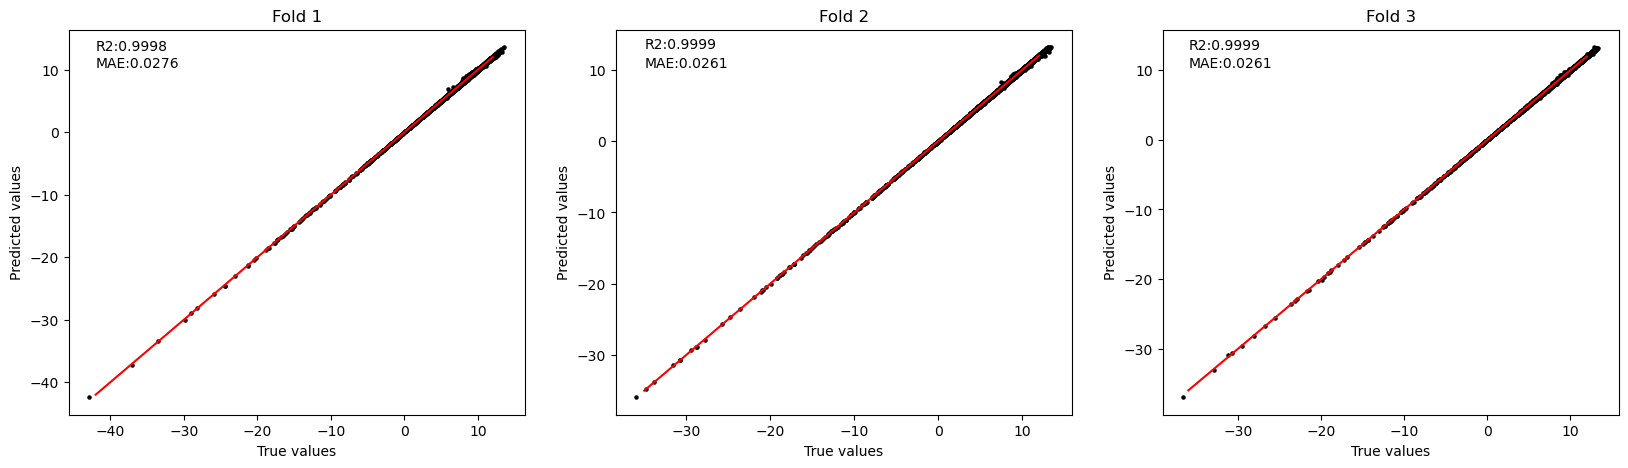

In [66]:
KRR = KernelRidge(**params)
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

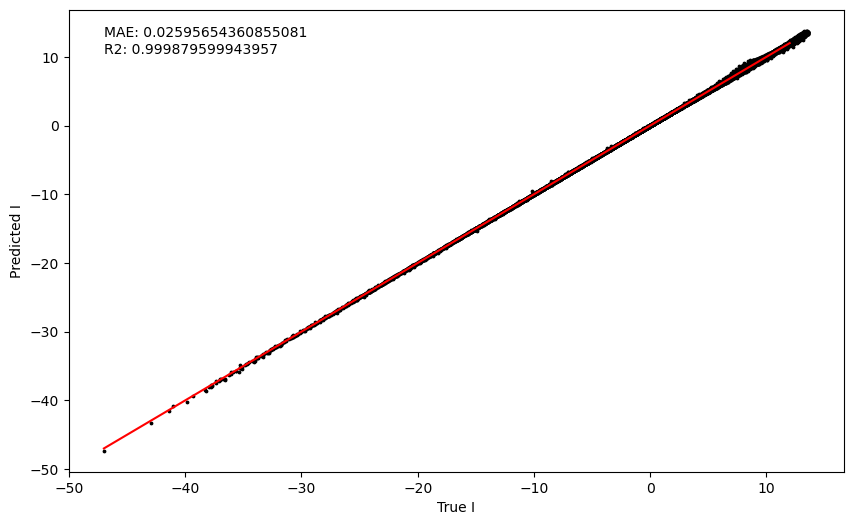

In [23]:
DF_5M = DF_full.sample(1000000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5M,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
#KRR = KernelRidge(**params)

#KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

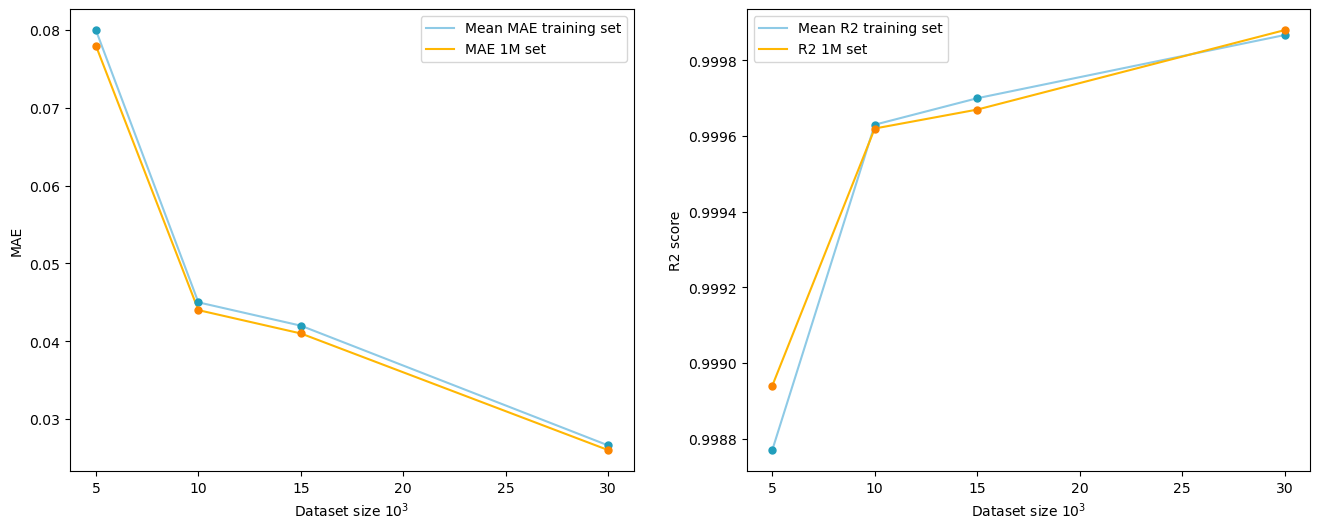

In [58]:
sizes = [5,10,15,30]
MAES = [0.080,0.045,0.042,0.0266]
MAES_large = [0.078,0.044,0.041,0.026]
R2s = [0.99877,0.99963,0.9997,0.999867]
R2s_large = [0.99894,0.99962,0.99967,0.99988]

f,ax = plt.subplots(nrows=1,ncols=2,figsize=[16,6])

ax[0].plot(sizes,MAES,color='#8ecae6',zorder=10,label='Mean MAE training set')
ax[0].scatter(sizes,MAES,c='#219ebc',s=25,zorder=1110)

ax[0].plot(sizes,MAES_large,color='#ffb703',zorder=10,label='MAE 1M set')
ax[0].scatter(sizes,MAES_large,c='#fb8500',s=25,zorder=1110)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles,labels)

_ = ax[0].set_xlabel('Dataset size $10^3$')
_ = ax[0].set_ylabel('MAE')


ax[1].plot(sizes,R2s,color='#8ecae6',zorder=10,label='Mean R2 training set')
ax[1].scatter(sizes,R2s,c='#219ebc',s=25,zorder=1110)

ax[1].plot(sizes,R2s_large,color='#ffb703',zorder=10,label='R2 1M set')
ax[1].scatter(sizes,R2s_large,c='#fb8500',s=25,zorder=1110)

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles,labels)

_ = ax[1].set_xlabel('Dataset size $10^3$')
_ = ax[1].set_ylabel('R2 score')

In [ ]:
import joblib
# Save the model to a file.
joblib.dump(KRR, save_path)